In [1]:


# Import the relevant modules of the library
import jax.numpy as jnp
import numpyro
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
     
     

In [2]:
#df = pd.read_csv('../../data/MMM.csv')

SEED = 105
data_size = 104 + 13
n_media_channels = 3
n_extra_features = 1

media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size=data_size,
    n_media_channels=n_media_channels, n_extra_features=n_extra_features,)
     

In [3]:
# Split and scale data.
split_point = data_size - 13
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]
     
print(costs)

[234.9729 235.9593 233.8534]


In [4]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

In [5]:
correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_data_train,
    target_data=target_train,
    cost_data=costs)

In [6]:
correlations[0].style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).format(precision=3)


,feature_0,feature_1,feature_2,target
feature_0,1.000,0.093,0.060,-0.042
feature_1,0.093,1.000,-0.052,0.257
feature_2,0.060,-0.052,1.000,0.185
target,-0.042,0.257,0.185,1.000


In [7]:
def highlight_variances(x: float, 
                        low_variance_threshold: float=1.0e-3, 
                        high_variance_threshold: float=3.0) -> str:

    if x < low_variance_threshold or x > high_variance_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

variances.style.format(precision=4).applymap(highlight_variances)

C:\Users\gomez\AppData\Local\Temp\ipykernel_36716\3750940654.py:14: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  variances.style.format(precision=4).applymap(highlight_variances)


,geo_0
feature_0,0.0062
feature_1,0.0050
feature_2,0.0051


In [8]:
def highlight_low_spend_fractions(x: float,
                                  low_spend_threshold: float=0.01) -> str:
    if x < low_spend_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

spend_fractions.style.format(precision=4).applymap(highlight_low_spend_fractions)


C:\Users\gomez\AppData\Local\Temp\ipykernel_36716\4135052178.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  spend_fractions.style.format(precision=4).applymap(highlight_low_spend_fractions)


,fraction of spend
feature_0,0.3334
feature_1,0.3348
feature_2,0.3318


In [9]:
def highlight_high_vif_values(x: float,
                              high_vif_threshold: float=7.0) -> str:
    if x > high_vif_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

variance_inflation_factors.style.format(precision=4).applymap(highlight_high_vif_values)


C:\Users\gomez\AppData\Local\Temp\ipykernel_36716\3340740960.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  variance_inflation_factors.style.format(precision=4).applymap(highlight_high_vif_values)


,geo_0
feature_0,1.0131
feature_1,1.0122
feature_2,1.0069


In [10]:
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

number_warmup=1000
number_samples=1000


mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    seed=SEED)


mmm.print_summary()


c:\Users\gomez\anaconda3\envs\tfm\lib\site-packages\lightweight_mmm\lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:25<00:00, 79.32it/s, 255 steps of size 1.62e-02. acc. prob=0.91] 



                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.53      0.28      0.52      0.13      1.00   2110.15      1.00
ad_effect_retention_rate[1]      0.33      0.19      0.30      0.01      0.60   1645.75      1.00
ad_effect_retention_rate[2]      0.38      0.25      0.34      0.01      0.76   1555.62      1.00
     coef_extra_features[0]      0.03      0.01      0.03      0.01      0.05   1873.87      1.00
              coef_media[0]      0.01      0.01      0.01      0.00      0.03   1649.92      1.00
              coef_media[1]      0.14      0.05      0.14      0.06      0.21   1357.72      1.00
              coef_media[2]      0.07      0.05      0.07      0.00      0.14    686.82      1.00
              coef_trend[0]     -0.00      0.00     -0.00     -0.00      0.00   1385.86      1.00
                 expo_trend      0.65      0.14      0.61      0.50      0.85   1004.76      1.00
                exp

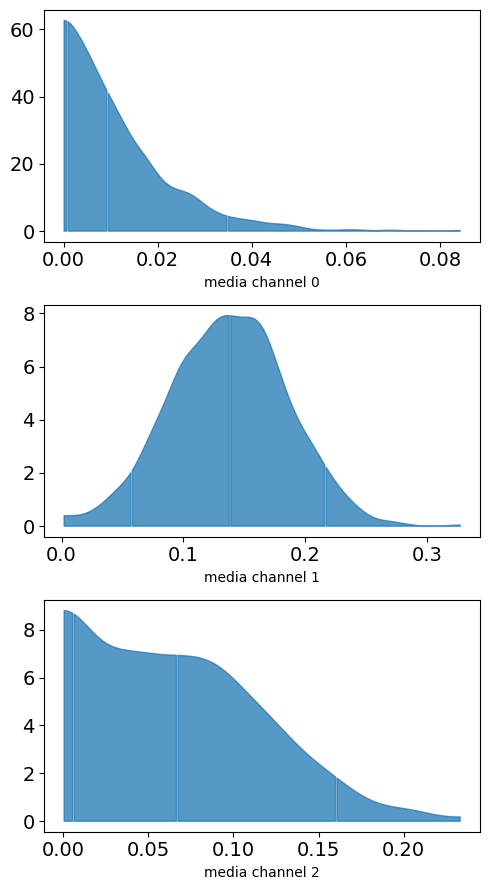

In [11]:
plot.plot_media_channel_posteriors(media_mix_model=mmm)


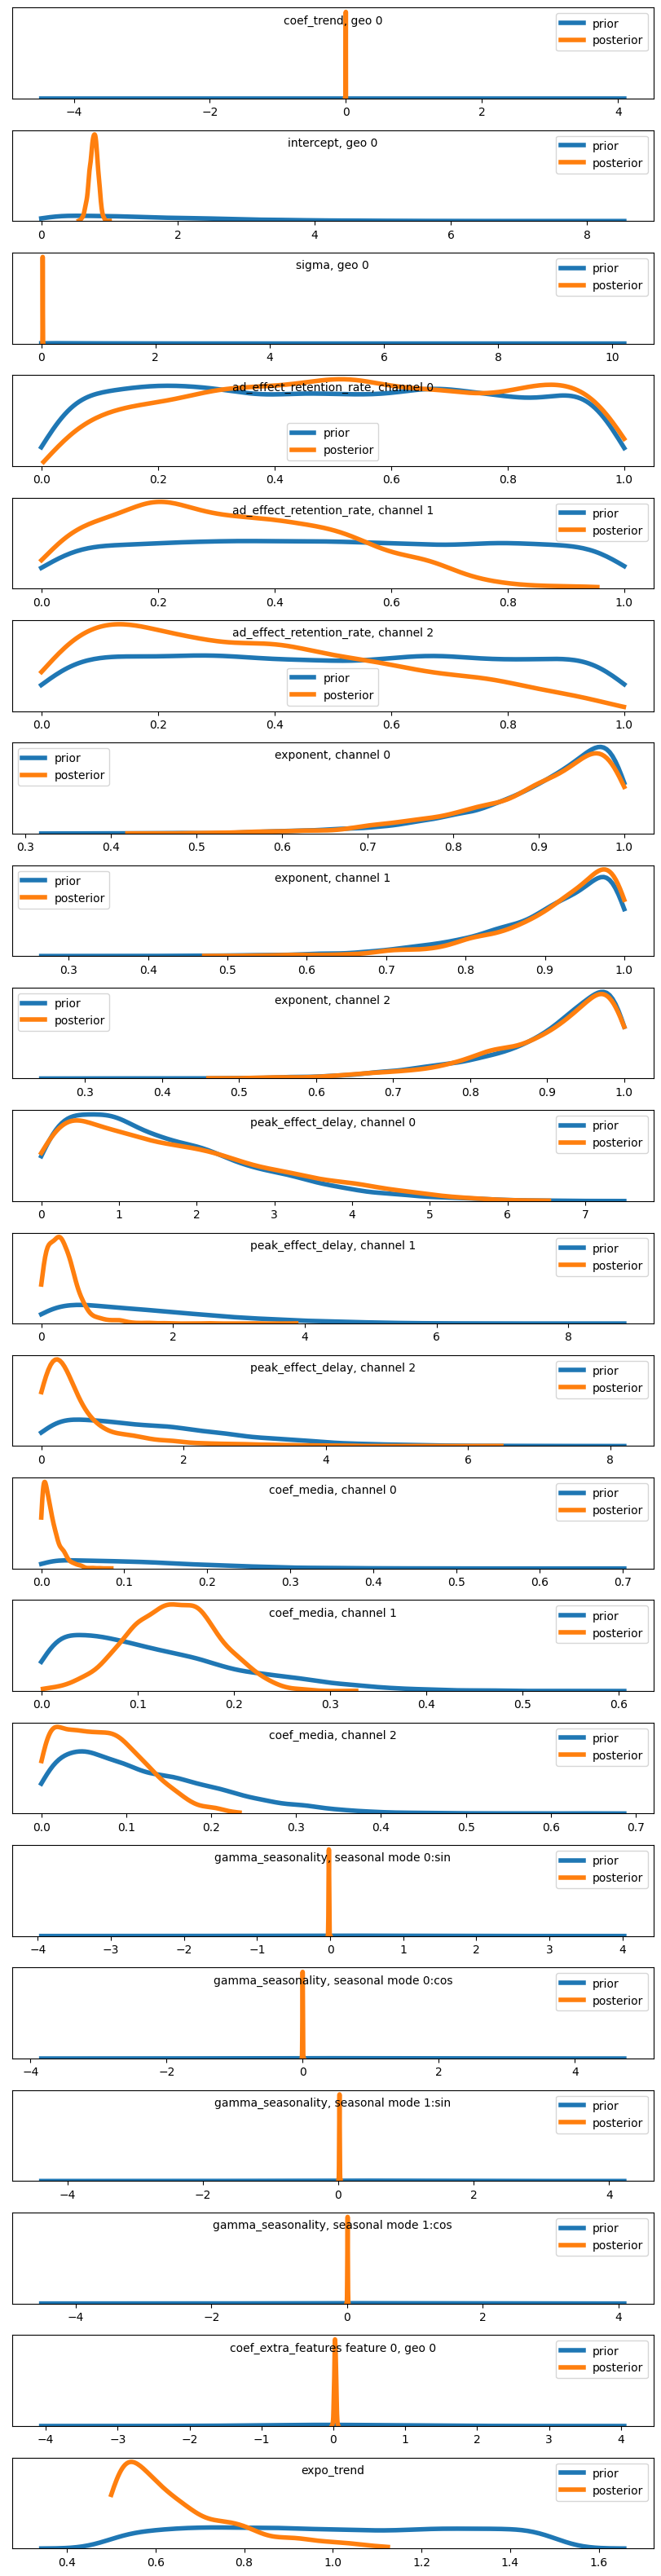

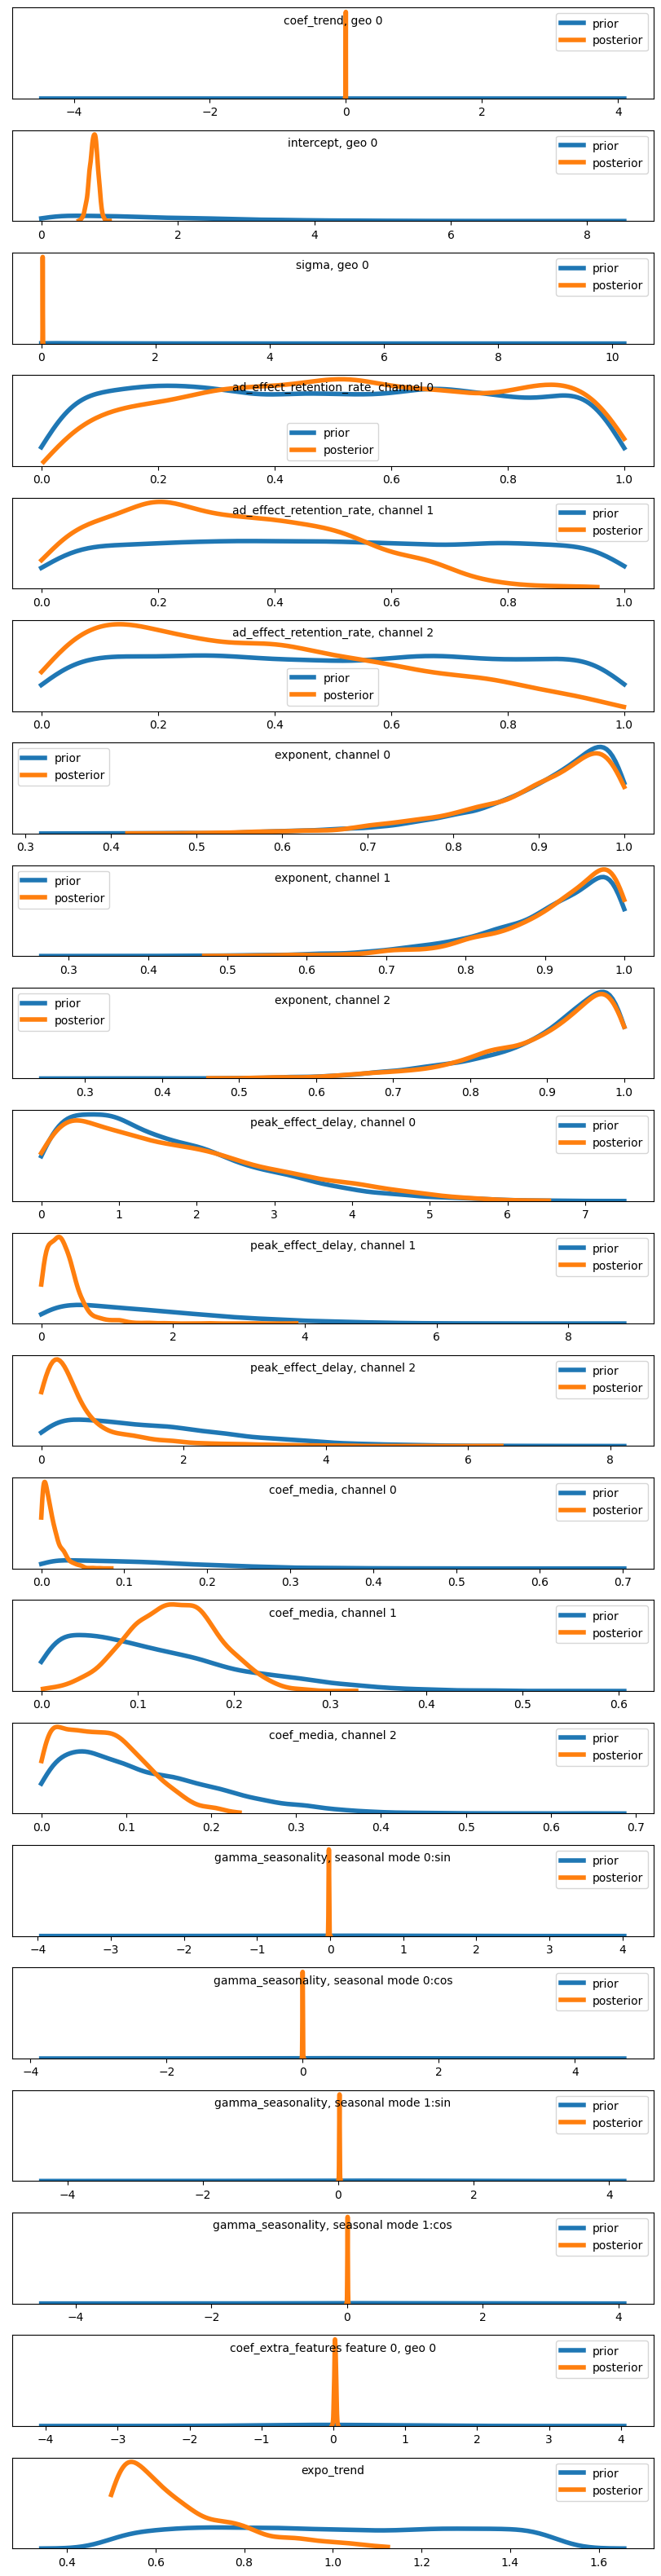

In [12]:
plot.plot_prior_and_posterior(media_mix_model=mmm)


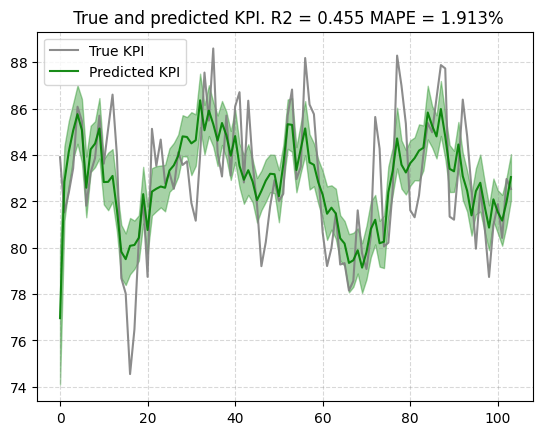

In [13]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [21]:
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)
new_predictions.shape

(2000, 13)

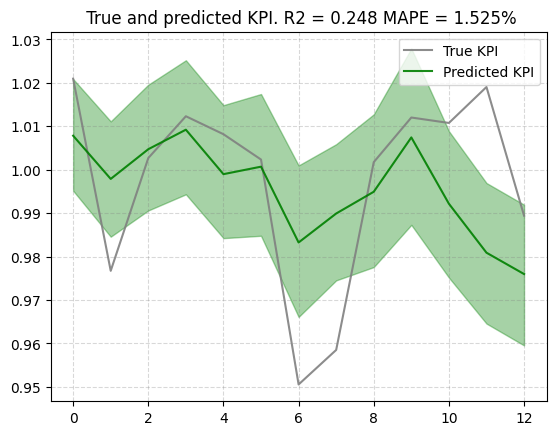

In [22]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

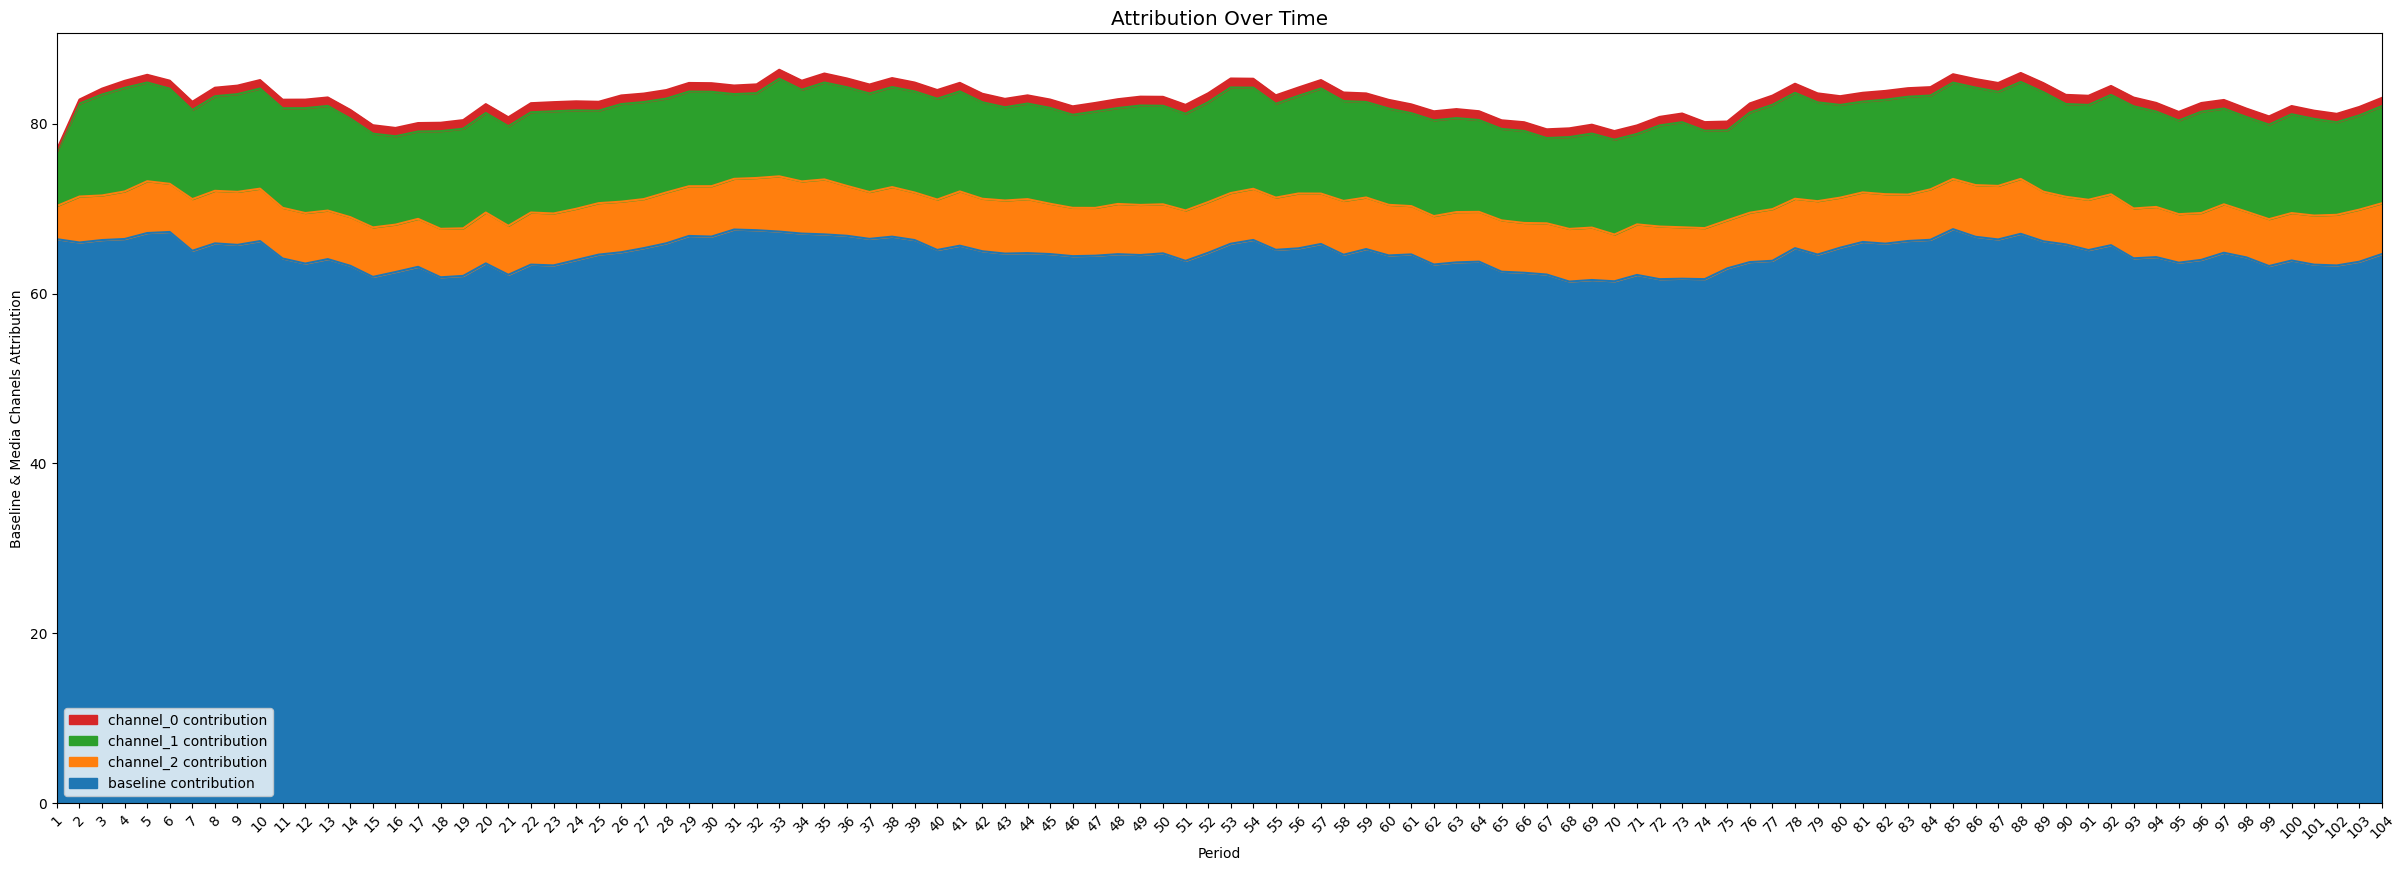

In [14]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10))

In [15]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)


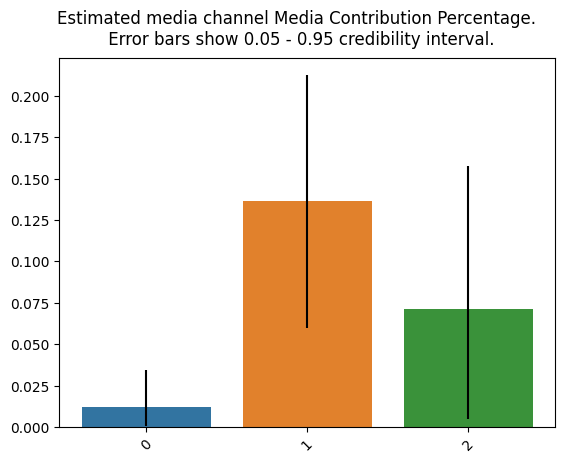

In [16]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")


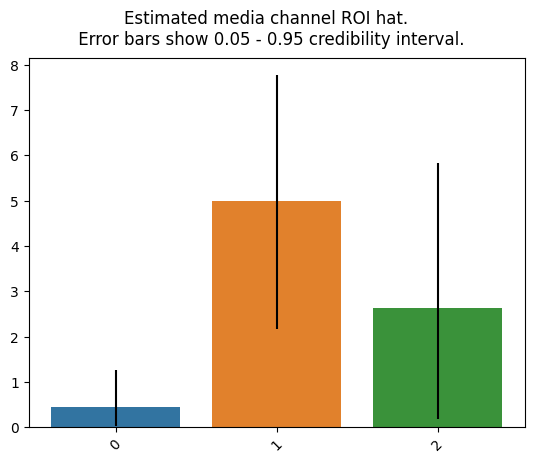

In [17]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")


In [18]:
prices = jnp.ones(mmm.n_media_channels)


In [19]:
n_time_periods = 10
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [20]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -846.9195666644898
            Iterations: 9
            Function evaluations: 63
            Gradient evaluations: 9


In [23]:
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([160.70435, 241.36108, 200.31549], dtype=float32)

In [24]:
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation
     

Array([200.82391, 201.07762, 200.47939], dtype=float32)

In [25]:
budget, optimal_buget_allocation.sum()


(Array(602.3809, dtype=float32), Array(602.3809, dtype=float32))

In [26]:
budget, jnp.sum(solution.x * prices)


(Array(602.3809, dtype=float32), Array(602.3809, dtype=float32))

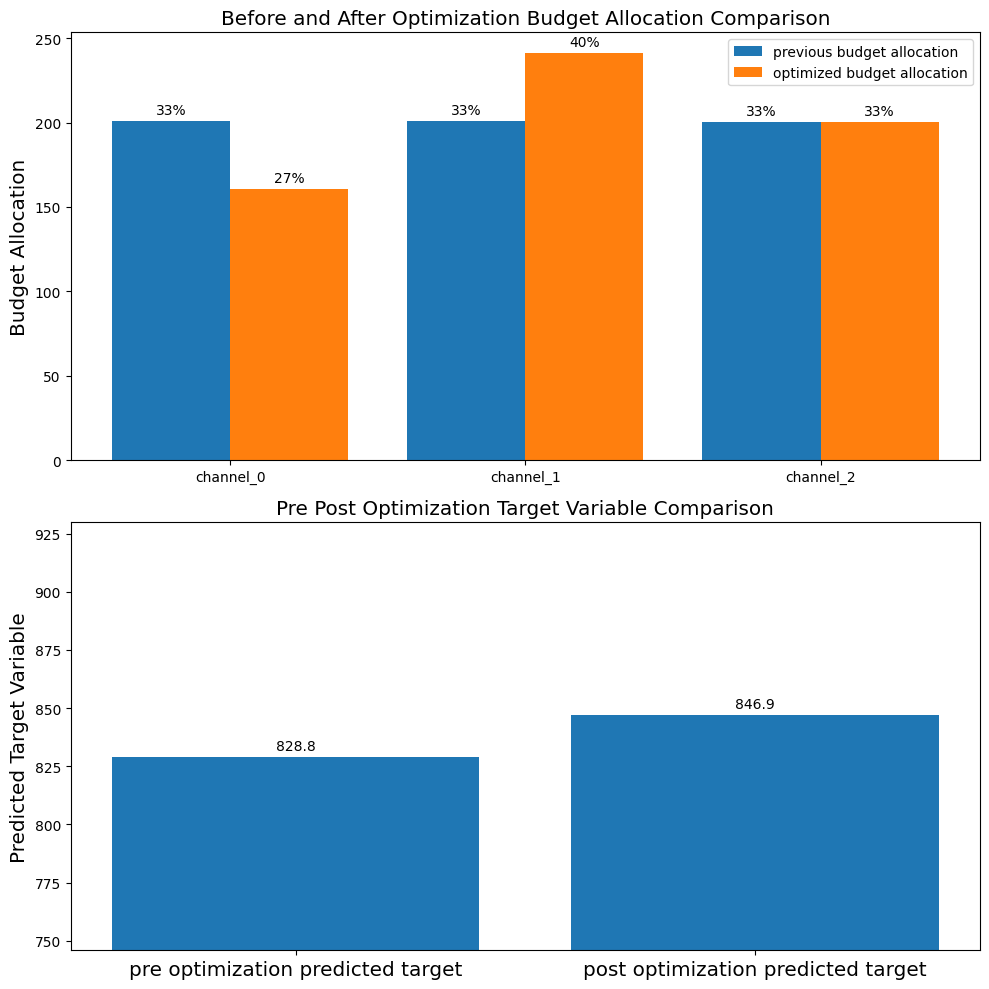

In [27]:
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10))